In [1]:
import os
import numpy as np
import rasterio as rio
import fiona
from datetime import date
from osgeo import gdal
from utils import *
from rasterio.windows import from_bounds
from rasterstats import zonal_stats

In [2]:
# set GCS credentials
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = os.path.join(os.getcwd(), 'gcs_config.json')
gdal.SetConfigOption('GOOGLE_APPLICATION_CREDENTIALS', os.environ.get('GOOGLE_APPLICATION_CREDENTIALS'))

In [3]:
# data config
DATA_DIR = '../../data'
IN_DIR = os.path.join(DATA_DIR, 'test')
OUT_DIR = os.path.join(DATA_DIR, 'output')
SHP_FN = 'test.shp'
contextual_layers = []
start_date = date(2019, 1, 1)
end_date = date(2020, 9, 15)

shp_fp = os.path.join(IN_DIR, SHP_FN)

In [4]:
with fiona.open(shp_fp) as src:
    bounds = src.bounds
bounds

(-63.14392089843749,
 -10.225734322414585,
 -62.3309326171875,
 -9.703642540353856)

In [5]:
latest_alerts = list_gcs_assets(
    'earthenginepartners-hansen', 
    'S2alert/alertDate',
    os.environ.get('GOOGLE_APPLICATION_CREDENTIALS')
)

In [6]:
# build VRT
vrt = gdal.BuildVRT('gdal_s2.vrt', latest_alerts)
vrt.FlushCache()

In [7]:
# read window
with rio.open('gdal_s2.vrt') as src:
    window = from_bounds(
        bounds[0],
        bounds[1],
        bounds[2],
        bounds[3],
        src.transform
    )
    arr = src.read(1,window=window)
    win_affine = src.window_transform(window)

In [8]:
feature = intersect_layers(bounds=bounds, shp_fp=shp_fp)

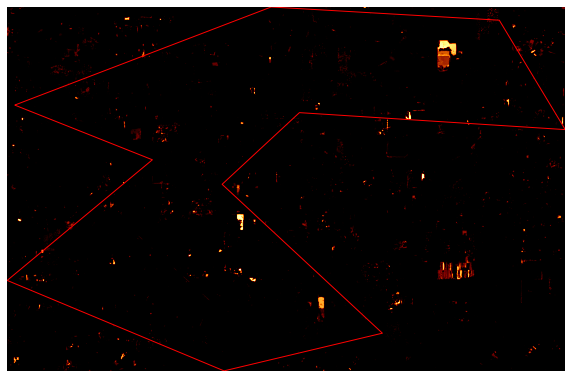

In [9]:
# display
overlay_feature_on_arr(feature, arr, win_affine, 'afmhot')

In [10]:
# mask by date
orig_date = date(2019, 1, 1)
max_date = end_date - orig_date
min_date = start_date - orig_date

In [42]:
arr_mask = arr.copy()
arr_mask[(arr > min_date.days) & (arr < max_date.days)] = 1
arr_mask[np.where(arr_mask != 1 )] = 0

In [51]:
zstats = zonal_stats(
    shp_fp,
    arr_mask,
    stats='sum',
    affine=win_affine,
    all_touched=False,
    nodata = 999
)

In [55]:
int(zstats[0]['sum'])

175109